In [1]:
import numpy as np
import sys
import pandas as pd
from matplotlib import pyplot as plt
sys.path.append('/home/cayjobla/Desktop/Research/delay-optimizer')
from DelayEffects.Analyzer import Analyzer

In [2]:
loss_name = 'Rosenbrock'

## Defining Delay Types

In [3]:
def undelayed(analyzer):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Undelayed
    """
    # Optimize
    analyzer.calculate_save_values(False, save_grad=False, save_state=False, 
                                   save_iters=False, break_opt=False)
    return np.mean(analyzer.final_losses)

def uniform(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Persistent 
        (delayed by max_L in all dimensions)
    """
    # Define delays
    D = [analyzer.max_L * np.ones(analyzer.n, dtype=int)]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def stochastic(analyzer, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Stochastic 
        (delayed randomly in each dimension at each time step)
    """
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=None, random=True, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def decaying(analyzer, stochastic=False):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Decaying 
        (max_L decays over time)
    """
    # Get array of decaying max_Ls
    m = analyzer.maxiter / (analyzer.max_L+1)
    L = np.repeat(np.arange(analyzer.max_L+1)[::-1], m)
    L = np.pad(L, (0,analyzer.maxiter-len(L)))
    
    # Define delays
    if stochastic is True:
        D = [np.random.randint(0,l+1,size=analyzer.n) for l in L]
    else:
        D = [l*np.ones(analyzer.n, dtype=int) for l in L]
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=analyzer.maxiter, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

def partial(analyzer, p, stochastic=False, num_delays=None):
    """Returns the mean of the final loss values after optimization.
    Optimization type : Partial 
        (p percent of the dimensions are delayed)
    """
    # Determine how many dimensions are delayed
    d = int(p * analyzer.n)
    if d == 0: d = 1
    
    # Choose which dimensions to delay at each time step
    dims = [np.random.choice(np.arange(0,analyzer.n), replace=False, size=d) 
            for i in range(analyzer.maxiter)]
    
    # Define delays
    D = [np.zeros(analyzer.n, dtype=int) for i in range(analyzer.maxiter)]
    if stochastic is True:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = np.random.randint(1, analyzer.max_L+1, size=d)
    else:
        for i in range(analyzer.maxiter):
            D[i][dims[i]] = analyzer.max_L
    
    # Optimize
    analyzer.calculate_save_values(True, num_delays=num_delays, D=D, random=False, 
                                   save_grad=False, save_state=False, save_iters=False, 
                                   break_opt=False)
    return np.mean(analyzer.del_final_losses)

In [4]:
def calc_means(analyzer, num_points, p, num_delays=None):
    # Initialize
    analyzer.initialize_points(num_points, 'random')
    
    # Get final loss means
    undelayed_mean = undelayed(analyzer)
    uniform_full_mean = uniform(analyzer, analyzer.maxiter)
    uniform_mean = uniform(analyzer, num_delays)
    stoch_full_mean = stochastic(analyzer, analyzer.maxiter)
    stoch_mean = stochastic(analyzer, num_delays)
    decay_mean = decaying(analyzer, False)
    decay_stoch_mean = decaying(analyzer, True)
    partial_mean = partial(analyzer, p, False, analyzer.maxiter)
    partial_stoch_mean = partial(analyzer, p, True, analyzer.maxiter)
    
    means = [undelayed_mean, uniform_full_mean, uniform_mean, stoch_full_mean, stoch_mean, 
             decay_mean, decay_stoch_mean, partial_mean, partial_stoch_mean]
    return means
    
def plot_means(means):
    first_bars = [means[1], means[3], means[5], means[7]]
    second_bars = [means[2], means[4], means[6], means[8]]
    width = 0.35
    ind = np.arange(5)
    
    plt.bar([width/2], [means[0]], width, color='C1')
    plt.bar(ind[1:], first_bars, width, color=['C0', 'C2', 'C3', 'C4'])
    plt.bar(ind[1:] + width, second_bars, width, color=['C0', 'C2', 'C3', 'C4'], 
            alpha=0.5)
    
    delay_names = ["Undelayed", "Uniform", "Stochastic", "Decaying", "Partial"]
    plt.xticks(ind+width/2, delay_names, rotation='vertical', fontsize=12)

In [5]:
# Initialize for max_L = 1
max_L = 1
rosen2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
rosen10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
rosen100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
rosen1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

## Parameter Testing

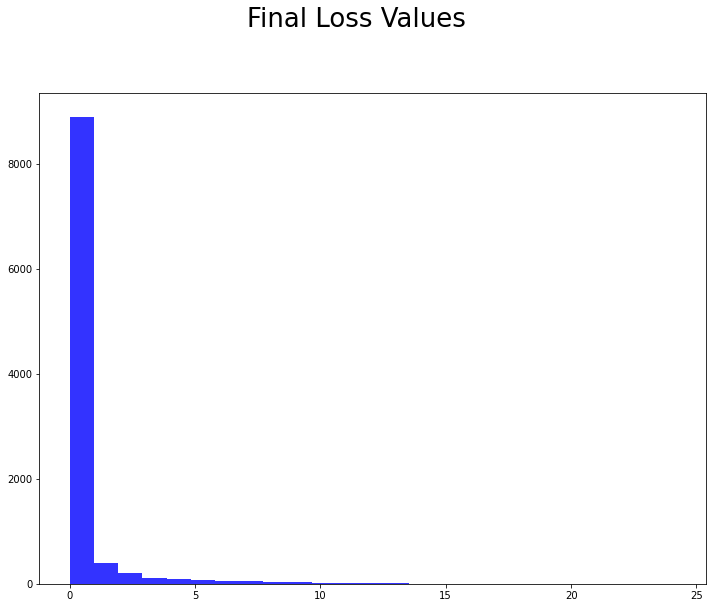

Minimum Loss: 1.0965806742355082e-08
Mean Loss: 0.49975813117050294
Median Loss: 0.0035900357377241393


In [14]:
# 2d params
rosen2d.params = {'step_size': 1300.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
rosen2d.optimize(10000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)

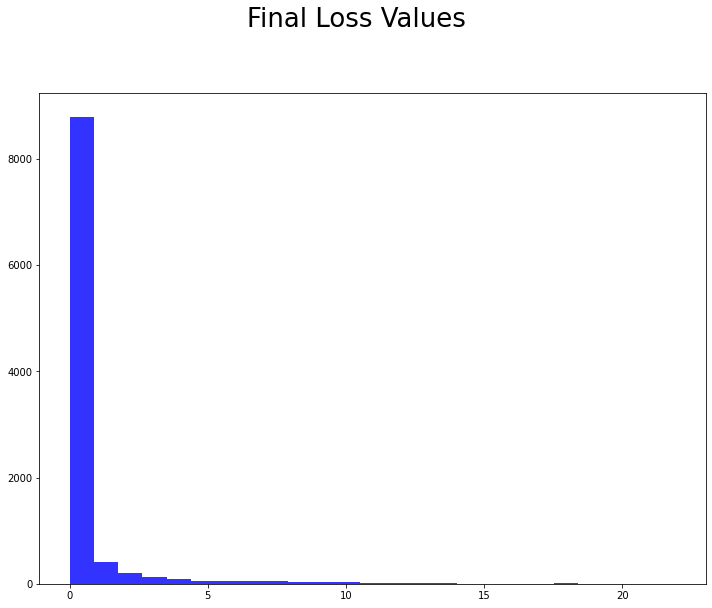

Minimum Loss: 1.0476014678076884e-08
Mean Loss: 0.5692811103216978
Median Loss: 0.0036702596167966324


In [17]:
# 2d params
rosen2d.params = {'step_size': 1150.0, 'min_learning_rate': 0.51, 'max_learning_rate': 3.24}
rosen2d.optimize(10000, 'random', False, [(False, 'finals', 'loss')], break_opt=True)

# These parameters seem to work fairly well for all dimensions, so supercomputer optimization 
# will focus around these params

In [7]:
means2d = calc_means(rosen2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(rosen10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(rosen100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(rosen1000d, 1000, 0.5, num_delays=1000)

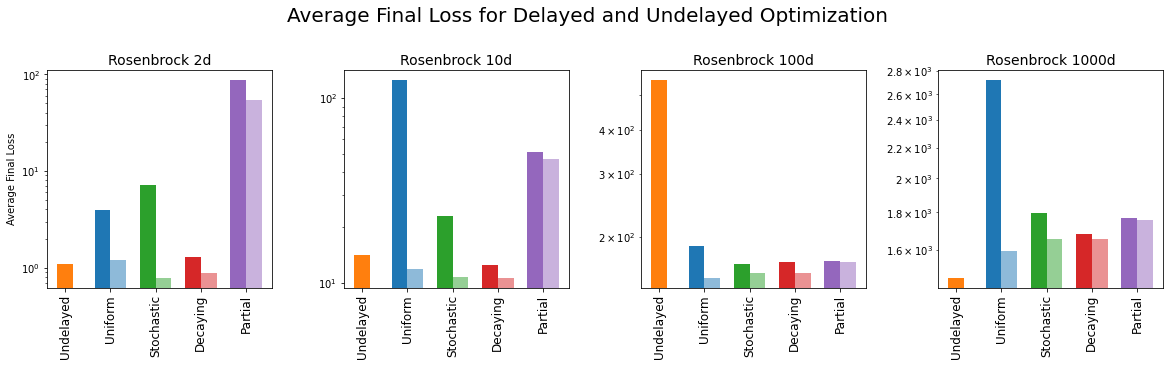

In [8]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Rosenbrock 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Rosenbrock 10d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(143)
plot_means(means100d)
plt.title("Rosenbrock 100d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(144)
plot_means(means1000d)
plt.title("Rosenbrock 1000d", fontsize=14)
ax.set_yscale('log')

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("rosen_types1.png", bbox_inches="tight")
plt.show()

In [8]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("rosen_means1.npy", means)

In [9]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Rosenbrock {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Rosenbrock 2d
Undelayed: 1.9442974005044134
Uniform full iters: 3.1177709965791967
Uniform delay: 2.814759268250541
Stochastic full iters: 3.3301819625166824
Stochastic delay: 2.8897243101452816
Decaying delay: 2.8624154035321054
Decaying Stochastic: 3.2369023472135434
Partial delay: 3.1630989323041905
Partial Stochastic: 3.3556755642563667


Rosenbrock 10d
Undelayed: 13.143621224536538
Uniform full iters: 75.9665125957185
Uniform delay: 13.483937009900176
Stochastic full iters: 32.6324172831938
Stochastic delay: 11.380768661125503
Decaying delay: 13.307280994183257
Decaying Stochastic: 9.891275425488548
Partial delay: 39.43208267736632
Partial Stochastic: 34.00693868003575


Rosenbrock 100d
Undelayed: 158.62986881099695
Uniform full iters: 199.05777911108424
Uniform delay: 130.52052141814127
Stochastic full iters: 191.474948911858
Stochastic delay: 129.9138978205419
Decaying delay: 134.38433763423117
Decaying Stochastic: 130.85612933248046
Partial delay: 177.0839444374118
Partial Stoc

In [5]:
# Initialize for max_L = 2
max_L = 2
rosen2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
rosen10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
rosen100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
rosen1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [6]:
means2d = calc_means(rosen2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(rosen10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(rosen100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(rosen1000d, 1000, 0.5, num_delays=1000)

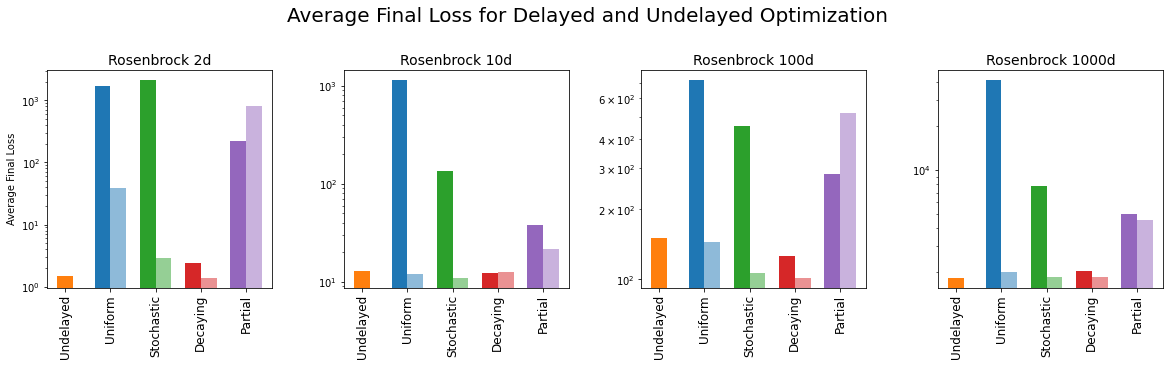

In [7]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Rosenbrock 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Rosenbrock 10d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(143)
plot_means(means100d)
plt.title("Rosenbrock 100d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(144)
plot_means(means1000d)
plt.title("Rosenbrock 1000d", fontsize=14)
ax.set_yscale('log')

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("rosen_types2.png", bbox_inches="tight")
plt.show()

In [8]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("rosen_means2.npy", means)

In [9]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Rosenbrock {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Rosenbrock 2d
Undelayed: 1.46906175291321
Uniform full iters: 1710.1772529768873
Uniform delay: 39.378378523236364
Stochastic full iters: 2121.3408285954074
Stochastic delay: 2.8574989236015025
Decaying delay: 2.393142343518232
Decaying Stochastic: 1.401732526044394
Partial delay: 225.3860145608925
Partial Stochastic: 804.1887945008507


Rosenbrock 10d
Undelayed: 12.741755867232905
Uniform full iters: 1148.491446425277
Uniform delay: 12.022006414019092
Stochastic full iters: 136.35510782961006
Stochastic delay: 10.994872850680974
Decaying delay: 12.328705813072927
Decaying Stochastic: 12.654142453185425
Partial delay: 38.28142689665715
Partial Stochastic: 21.783277565041093


Rosenbrock 100d
Undelayed: 150.15201723668787
Uniform full iters: 719.5207372124856
Uniform delay: 144.64917582953123
Stochastic full iters: 455.1547442047099
Stochastic delay: 106.17690042967622
Decaying delay: 126.24584539784226
Decaying Stochastic: 101.6707049659594
Partial delay: 284.3823182180564
Partial Stoc

In [10]:
# Initialize for max_L = 3
max_L = 3
rosen2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
rosen10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
rosen100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
rosen1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [11]:
means2d = calc_means(rosen2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(rosen10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(rosen100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(rosen1000d, 1000, 0.5, num_delays=1000)

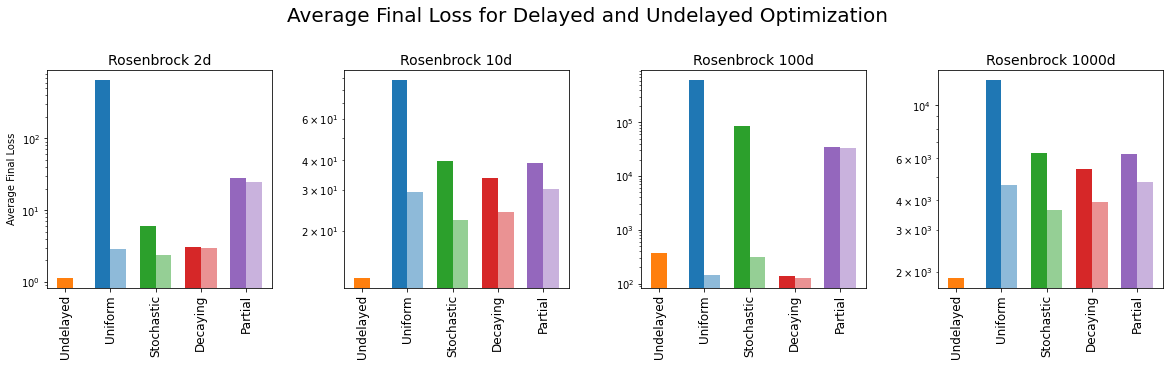

In [12]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Rosenbrock 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Rosenbrock 10d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(143)
plot_means(means100d)
plt.title("Rosenbrock 100d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(144)
plot_means(means1000d)
plt.title("Rosenbrock 1000d", fontsize=14)
ax.set_yscale('log')

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("rosen_types3.png", bbox_inches="tight")
plt.show()

In [13]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("rosen_means3.npy", means)

In [14]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Rosenbrock {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Rosenbrock 2d
Undelayed: 1.1465865707615688
Uniform full iters: 650.7651316381061
Uniform delay: 2.863586395469341
Stochastic full iters: 6.092780497675928
Stochastic delay: 2.3705483932140137
Decaying delay: 3.06747037363258
Decaying Stochastic: 2.9321935773393673
Partial delay: 28.05419472843496
Partial Stochastic: 24.904152666252497


Rosenbrock 10d
Undelayed: 12.635336965391213
Uniform full iters: 88.1000105827279
Uniform delay: 29.355833035527223
Stochastic full iters: 39.660298103661326
Stochastic delay: 22.18857541910809
Decaying delay: 33.67378091276623
Decaying Stochastic: 24.08362957872047
Partial delay: 39.13137010099691
Partial Stochastic: 30.064240861482972


Rosenbrock 100d
Undelayed: 364.6583495967904
Uniform full iters: 614038.8133120585
Uniform delay: 142.90788613984077
Stochastic full iters: 84449.0170494087
Stochastic delay: 308.8977747803705
Decaying delay: 135.5842283609352
Decaying Stochastic: 128.62131652575658
Partial delay: 34876.16937826933
Partial Stochastic:

In [15]:
# Initialize for max_L = 4
max_L = 4
rosen2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
rosen10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
rosen100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
rosen1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [16]:
means2d = calc_means(rosen2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(rosen10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(rosen100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(rosen1000d, 1000, 0.5, num_delays=1000)

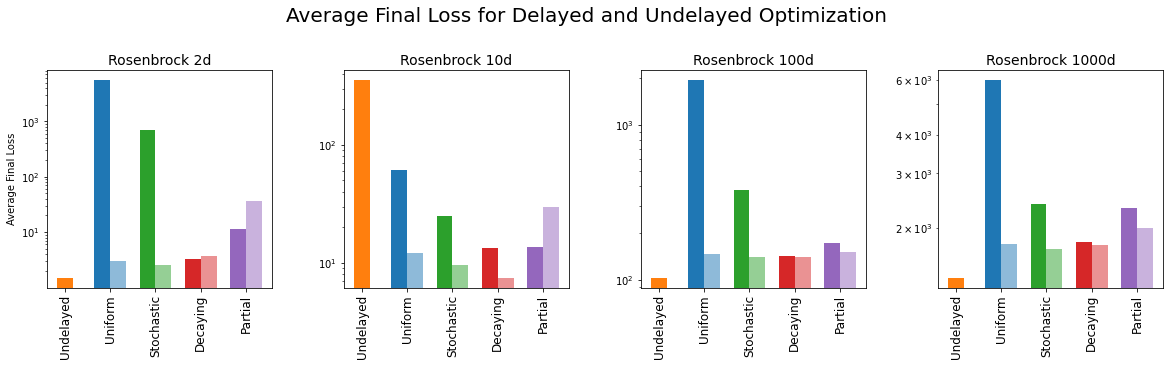

In [17]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Rosenbrock 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Rosenbrock 10d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(143)
plot_means(means100d)
plt.title("Rosenbrock 100d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(144)
plot_means(means1000d)
plt.title("Rosenbrock 1000d", fontsize=14)
ax.set_yscale('log')

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("rosen_types3.png", bbox_inches="tight")
plt.show()

In [18]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("rosen_means4.npy", means)

In [19]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Rosenbrock {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Rosenbrock 2d
Undelayed: 1.5084412602647381
Uniform full iters: 5566.4986791798565
Uniform delay: 3.0628305370448725
Stochastic full iters: 688.7438222784509
Stochastic delay: 2.5504009425642544
Decaying delay: 3.3132286583293706
Decaying Stochastic: 3.753718185612045
Partial delay: 11.30872734070247
Partial Stochastic: 36.286104539583135


Rosenbrock 10d
Undelayed: 355.4393681070204
Uniform full iters: 60.87219072663527
Uniform delay: 12.015348545568013
Stochastic full iters: 24.881954718088004
Stochastic delay: 9.618822893436445
Decaying delay: 13.478907699501539
Decaying Stochastic: 7.492336209248781
Partial delay: 13.630738819629308
Partial Stochastic: 29.634748890284925


Rosenbrock 100d
Undelayed: 103.08939566439454
Uniform full iters: 1939.1986806030197
Uniform delay: 145.60464693261838
Stochastic full iters: 376.8778889015173
Stochastic delay: 140.92758697884778
Decaying delay: 141.72244851577787
Decaying Stochastic: 140.04987322143162
Partial delay: 171.47004142590578
Partial 

In [20]:
# Initialize for max_L = 5
max_L = 5
rosen2d = Analyzer(2, loss_name, max_L=max_L, verbose=False)
rosen10d = Analyzer(10, loss_name, max_L=max_L, verbose=False)
rosen100d = Analyzer(100, loss_name, max_L=max_L, verbose=False)
rosen1000d = Analyzer(1000, loss_name, max_L=max_L, verbose=False)

In [21]:
means2d = calc_means(rosen2d, 1000, 0.5, num_delays=1000)
means10d = calc_means(rosen10d, 1000, 0.5, num_delays=1000)
means100d = calc_means(rosen100d, 1000, 0.5, num_delays=1000)
means1000d = calc_means(rosen1000d, 1000, 0.5, num_delays=1000)

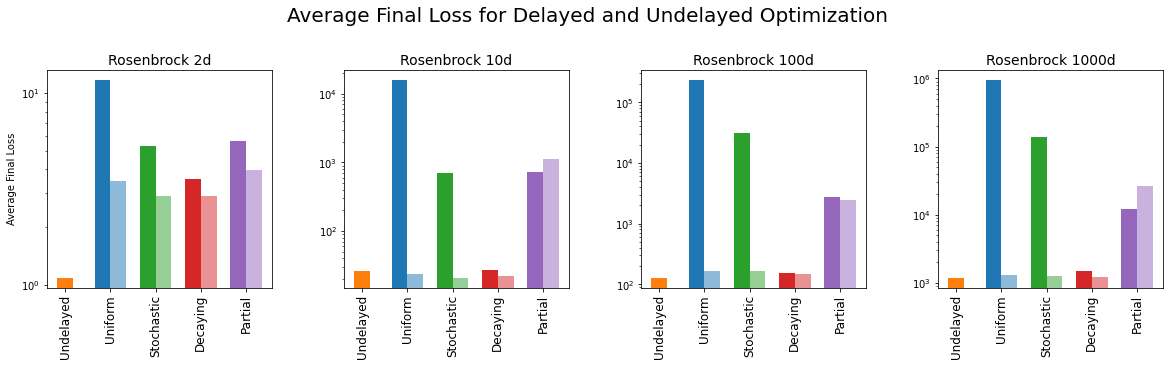

In [22]:
# Initialize figure
fig = plt.figure(figsize=(20, 4))
ax = fig.subplots(1, 4)

ax = plt.subplot(141)
plot_means(means2d)
plt.ylabel("Average Final Loss")
ax.set_yscale('log')
plt.title("Rosenbrock 2d", fontsize=14)

ax = plt.subplot(142)
plot_means(means10d)
plt.title("Rosenbrock 10d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(143)
plot_means(means100d)
plt.title("Rosenbrock 100d", fontsize=14)
ax.set_yscale('log')

ax = plt.subplot(144)
plot_means(means1000d)
plt.title("Rosenbrock 1000d", fontsize=14)
ax.set_yscale('log')

fig.suptitle("Average Final Loss for Delayed and Undelayed Optimization", y=1.1, size=20)
plt.subplots_adjust(wspace=0.32)
plt.savefig("rosen_types3.png", bbox_inches="tight")
plt.show()

In [23]:
means = np.array([means2d, means10d, means100d, means1000d])
np.save("rosen_means5.npy", means)

In [24]:
delay_name = ["Undelayed:", "Uniform full iters:", "Uniform delay:", "Stochastic full iters:", 
             "Stochastic delay:", "Decaying delay:", "Decaying Stochastic:", "Partial delay:",
             "Partial Stochastic:"]
means = {2:means2d, 10:means10d, 100:means100d, 1000:means1000d}

for n in [2, 10, 100, 1000]:
    print(f"Rosenbrock {n}d")
    for i in range(9):
        print(delay_name[i], means[n][i])
    print('\n')

Rosenbrock 2d
Undelayed: 1.0928428051734933
Uniform full iters: 11.676630888647864
Uniform delay: 3.488824815065173
Stochastic full iters: 5.283174880662597
Stochastic delay: 2.9025444869299917
Decaying delay: 3.575924007568169
Decaying Stochastic: 2.923923064245957
Partial delay: 5.602111407398381
Partial Stochastic: 3.9944564720314704


Rosenbrock 10d
Undelayed: 26.584750926422153
Uniform full iters: 15890.98363301282
Uniform delay: 23.92050554204639
Stochastic full iters: 708.65626930057
Stochastic delay: 20.968583869097458
Decaying delay: 26.69038006226102
Decaying Stochastic: 22.497508675829437
Partial delay: 720.7824096183715
Partial Stochastic: 1130.7716679127584


Rosenbrock 100d
Undelayed: 128.52508474913037
Uniform full iters: 232552.95155816767
Uniform delay: 163.94320243309951
Stochastic full iters: 31012.04210093353
Stochastic delay: 163.0260517405756
Decaying delay: 153.74300468437255
Decaying Stochastic: 149.93063504026168
Partial delay: 2695.8985862663462
Partial Stocha